## Self-Driving Car Nanodegree

### Vehicle Detection Project 5



#### Histogram of Oriented Gradients (HOG)

My initial strategy was to use a similar method as used in the classroom which is to combine spatial binning, Color Histogram and HOG features, I did this and ran a feature importance test on all the features and concluded that only the HOG features were particularly strong features and even then, not all of them, for this reason, I have chosen to only use the HOG features. 

The next step naturally, is deciding what color space to use and how many channels to use, I chose to first test out each individual channel and see how well they perform and to then decide based on this, the channels I found the strongest where - 


| Color Space  |  Channel |  Accuracy |
|---|---|---|
|  YCrCb | Y  |  0.9701 |
|  HSV |  H |  0.9657 |
|  RGB | R  |  0.9601 |
|  RGB | B  | 0.959  |


The other channels tried all returned accuracies of between 0.92 & 0.94, my initial plan here was to use all of these channels and run hog on all of them and this is what i did at first, another thing to note here is that even though the Y channel gave the highest score, not all features in the Y channel are powerful, as a matter of fact, investigating this further showed that only a handful of the features in each channel are any good at predicting, I chose to stop the feature selection step at this stage so it's not too complex, besides while this might simplify the model, it wouldn't necessarily speed up the process since we'd still need to perform HOG on all the channels anyway before selecting the useful features. 


I performed feature scaling to take care of the different scales when importing different image formats, this step is done along with stacking together the useful channels with the newSpace function which is present on line 9 in the postML.ipynb notebook. 


The process of training on the test images is in ML.ipynb & ML2.ipynb files, this is also where all the images where imported using the glob2 module, this was super efficient as I was able to import all the required files in one line of code. Below are some examples of the car & non-car images.

In [12]:
## Visualization helper function

def helper(image, titles, size=15):
    fig = plt.figure(figsize=(size, size))
    for i in range(len(titles)):
        a=fig.add_subplot(4,4,i+1)
        plot = plt.imshow(image[i], cmap='hot')
        a.set_title(titles[i])
        a.axis('off')
        


In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import glob2
import cv2
import warnings
warnings.filterwarnings('ignore')


cars = glob2.glob('vehicles\**\*.png')
notcars = glob2.glob('non-vehicles\**\*.png')

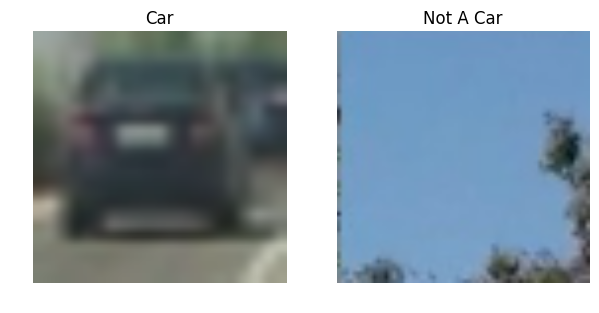

In [3]:
%matplotlib inline

titles = ["Car", "Not A Car"]
images = [mpimg.imread(cars[0]), mpimg.imread(notcars[0])]

helper(images, titles)

Along with trying different color spaces, I also played around with different HOG features and the best (going by the accuracy) were- 

orient --> 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block

Below are some images along with a visualization of their hog features

In [4]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features
    
    

orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"

In [5]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1), copy=True)
from skimage.feature import hog

def newSpace(image):
    R = scaler.fit_transform(image[:, :, 0])
    #B = scaler.fit_transform(image[:, :, 2])
    Y = scaler.fit_transform(cspace(image, color_space='YCrCb')[:, :, 0])
    L = scaler.fit_transform(cspace(image, color_space='HLS')[:, :, 0])
    return np.dstack((R, Y, L))
    
    
def cspace(image, color_space='RGB'):
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)    
    return feature_image

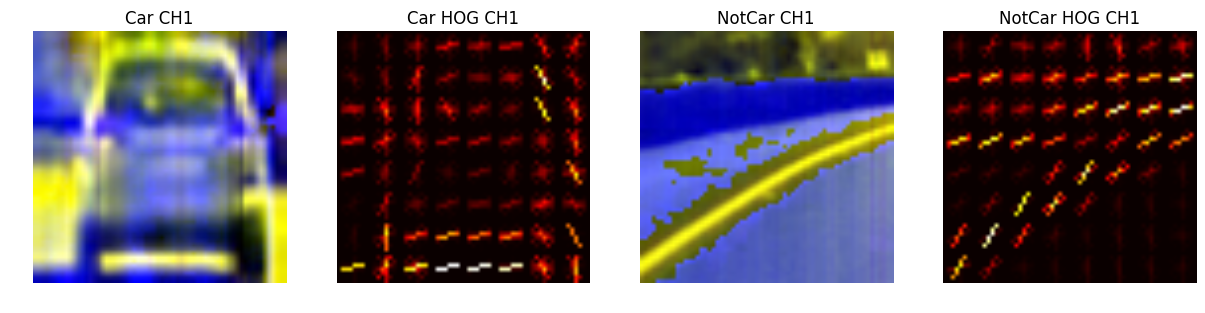

In [13]:
titles = ["Car CH1", "Car HOG CH1", "NotCar CH1", "NotCar HOG CH1"]

car = newSpace(mpimg.imread(cars[5]))
notcar = newSpace(mpimg.imread(notcars[5]))


carHog = get_hog_features(car[:, :, hog_channel], orient, pix_per_cell, cell_per_block, 
                        vis=True)
notcarHog = get_hog_features(notcar[:, :, hog_channel], orient, pix_per_cell, cell_per_block, 
                        vis=True)

images = [car, carHog[1], notcar, notcarHog[1]]

helper(images, titles)

### Classification

For this, I used a tried and true model for performance and that is the Exreme gradient Boosting Trees otherwise known as XGBoost, with a combination of the different channels, I was able to achieve an accuracy of 0.9, the code documenting this is contained in the ML.ipynb & ML2.ipynb files. One interesting thing about this model is that it predicts probabilities that the image is a car rather than a true or positive, this allows us to threshold based on a predetermined value based on how confident our model is of it's prediction. I used a threshold of 0.85 meaning I only expected the model to predict an image is a car if it's very confident in it's prediction, this can be used to reduce false positive detection. 

### Sliding Window Search

I chose to limit the search area to the areas where cars are likely to be which is from 800 to 1280 pixels for the X range and 400 to 700 for the Y range, I also attempted two differemt window sizes which are the 64x64 and double that to 128x128. Included is an image showing the search area. 

(-0.5, 1242.5, 831.5, -0.5)

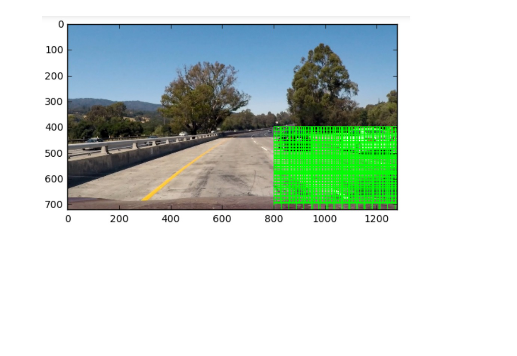

In [7]:
plt.imshow(mpimg.imread("coverage.jpg"))
plt.axis('off')

Due to the extremely long processing time, I had to cut down on some of the processes, for example, rather than running HOG on all channels, I now run it on only the Y channel, while this now speeds up the process a great deal but now resulting in a lot of false positives. Below are some examples showing detections on test images. 

In [8]:
import helper as h
import sys
sys.path.append("C:/xgboost/python-package")
import xgboost as xgb
bst = xgb.Booster(model_file='xgb.model')


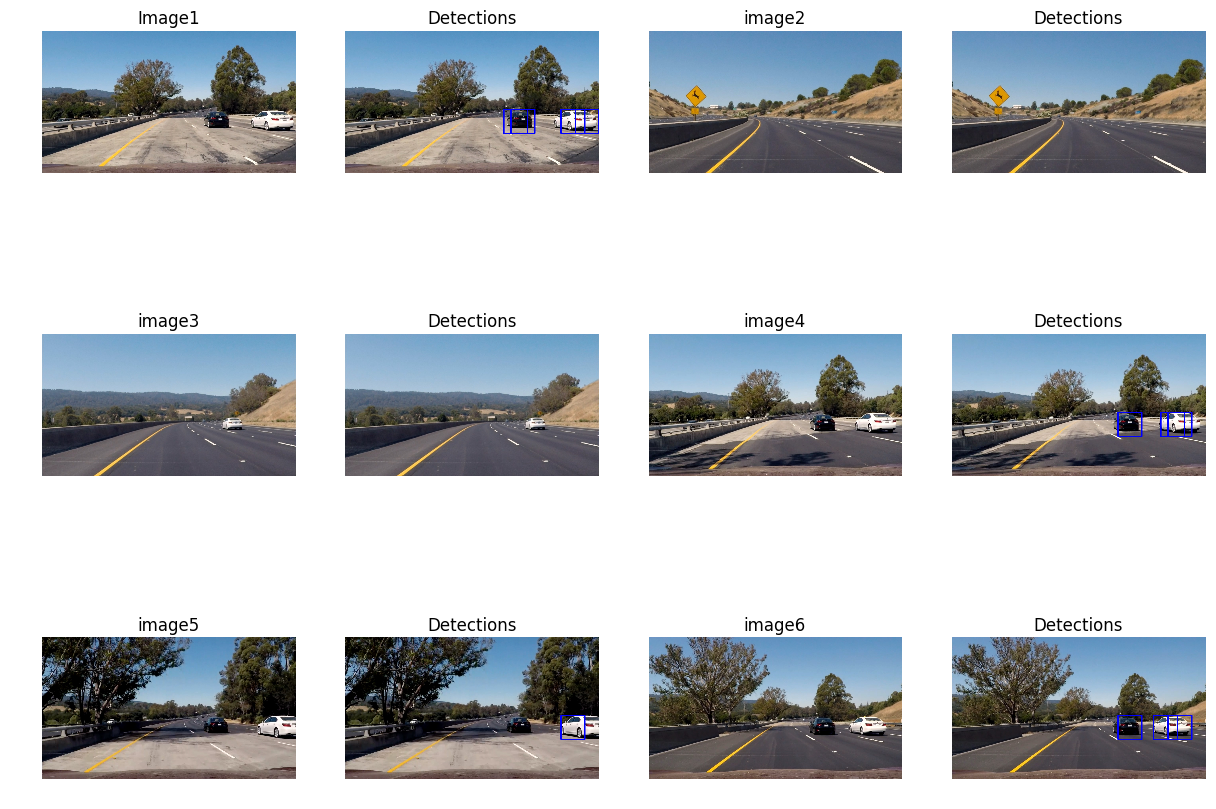

In [9]:
titles = ["Image1", "Detections", "image2", "Detections", "image3", "Detections", "image4", "Detections", "image5", "Detections", "image6", "Detections"]

testcars = glob2.glob('test_images\*.jpg')[2:]

images = []

for each in testcars:
    images.append(mpimg.imread(each))
    images.append(h.box(mpimg.imread(each), bst)[0])

helper(images, titles)

## Video Implementation


1. Here's a link to my video - 


https://youtu.be/7cxqVJYSudM



* To filter out false positives, I tried a number of things, as mentioned earlier, a threshold was added for the xgboost model such that only detections over 0.9 probability are classed as cars, this was especially necessary because the model now returns a lot of false positives due to the many features and feature types removed from the model to increase how long it takes to process the video. The Xgboost threshold occurs in the postML.ipynb file on line 191. 




* Another thing I tries was the heatmap threshold, I set the threshold to a value of 1, what happens here is that pixels contained in multiple detections are made hotter(pixel value increased by one while every other pixel is cooled), this way we can exclude pixel values for areas lower than that threshold. This occurs in the add_heat function on line 212 as well as processHeat on line 193. 


Below are the images as well as the heatmaps drawn for them. 

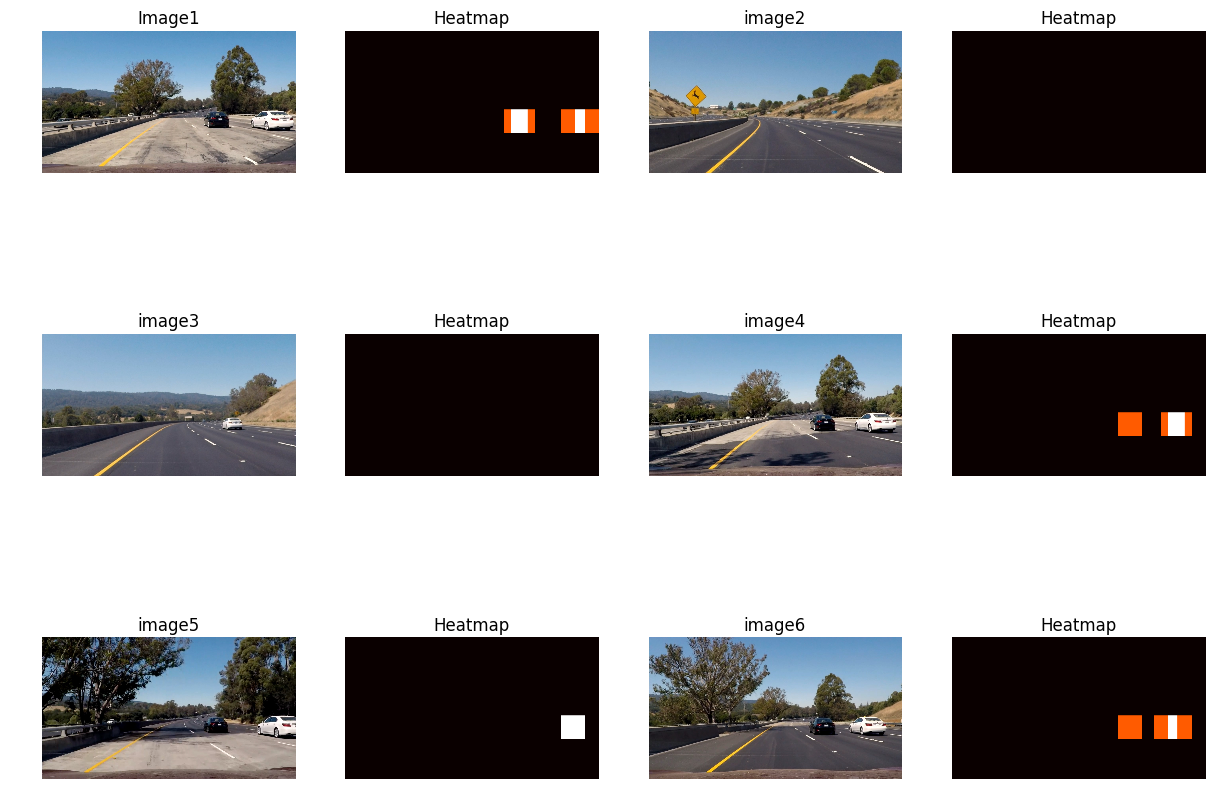

In [14]:
titles = ["Image1", "Heatmap", "image2", "Heatmap", "image3", "Heatmap", "image4", "Heatmap", "image5", "Heatmap", "image6", "Heatmap"]


images = []

for each in testcars:
    images.append(mpimg.imread(each))
    images.append(h.Heat(mpimg.imread(each), bst))

    
helper(images, titles)

And below is a visualization of the images after applying scipy.ndimage.measurements.label() on the images. 

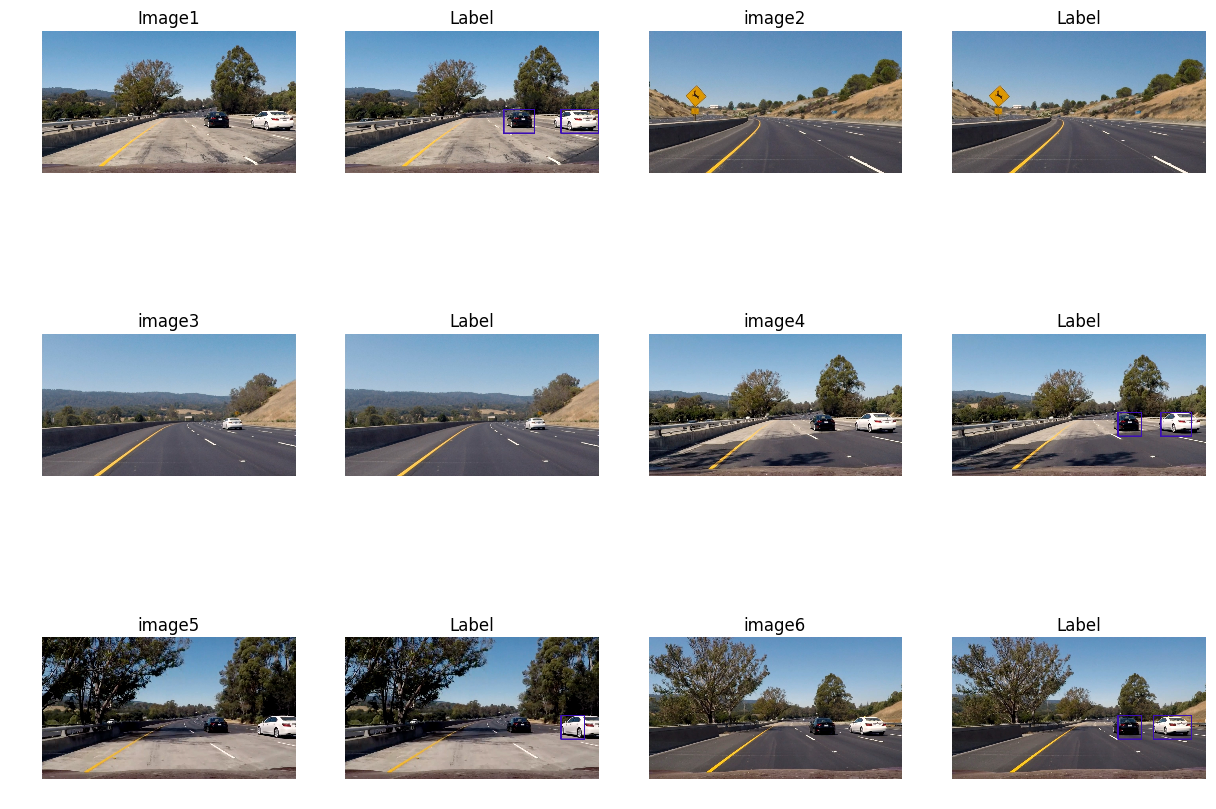

In [11]:
titles = ["Image1", "Label", "image2", "Label", "image3", "Label", "image4", "Label", "image5", "Label", "image6", "Label"]


images = []

for each in testcars:
    images.append(mpimg.imread(each))
    images.append(h.Label(mpimg.imread(each), bst))

    
helper(images, titles)

For the video implementation, I chose to sum up the heatmaps over the last 10 frames, this helped get a smoother movement of the bounding boxes from frame to frame, this is implemented in the postML.ipynb file in the search_windows_hog funtion on line 192-192, this was done by storing each heatmap in a list called temp and doing the summation in the pipeline function newPipeline on line 194. I found that the more frames I choose to sum, the higher the threshold would need to be to remove false positives. 

### Discussion


1. Briefly discuss any problems / issues you faced in your implementation of this project. Where will your pipeline likely fail? What could you do to make it more robust?


Because my background is in machine learning, I felt it was important to reduce the features as much as possible rather than simply adding together all the different types of features and using them, HOG features while very informative, take a long time and that is the main issue I faced with this project, I eventually had to remove a lot of the functionality and exclude most of the features I was using from about 10,000 down to 1,764 for HOG features on one channel. 



The downside to this was that it resulted in the model getting a lot of false positives. The simplest solution to this I believe would be to not use HOG at all and to instead use deep learning, with deep learning we can spend a long time training but not so long while predicting. I think, and I may be wrong, that the point of this project was to have an idea of the kind of processing that goes on in the background of a black box deep learning operation. 


The pipeline is likely to fail in any other video fed into it simply because the region of interest to search for here is limited to the bottom right corner of the image, and would not detect vehicles on the lower right or in front of us.

To make it more robust, I would as mentioned earlier, use deep learning. Also I would extend the region of interest to include every where a vehicle could be located. 